In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 1.7 MB/s 


# Sentiment Analysis: Using Recurrent Neural Networks

Like word similarity and analogy tasks,
we can also apply pretrained word vectors
to sentiment analysis.
We will do this on movie reviews, using the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/) with text representations
that were pretrained on large-scale corpora (GloVe model).
We feed these token representations
into a multilayer bidirectional RNN
to obtain the text sequence representation,
which will be transformed into 
sentiment analysis outputs :cite:`Maas.Daly.Pham.ea.2011`.

![This section feeds pretrained GloVe to an RNN-based architecture for sentiment analysis.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/nlp-map-sa-rnn.svg?raw=1)


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

#import torch.nn.functional as f
import numpy as np
import torchtext.legacy.data as data
import torchtext.legacy.datasets as datasets
import math


#batch_size = 64
#train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)
max_len = 200
text = data.Field(sequential=True, fix_length=max_len, batch_first=True, lower=True, dtype=torch.long)
label = data.LabelField(sequential=False, dtype=torch.long)
datasets.IMDB.download('./')
ds_train, ds_test = datasets.IMDB.splits(text, label, path='./imdb/aclImdb/')
print('train : ', len(ds_train))
print('test : ', len(ds_test))
print('train.fields :', ds_train.fields)


downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 55.2MB/s]


train :  25000
test :  25000
train.fields : {'text': <torchtext.legacy.data.field.Field object at 0x7fc346e97c10>, 'label': <torchtext.legacy.data.field.LabelField object at 0x7fc43a276b90>}


In [3]:
ds_train, ds_valid = ds_train.split(0.9)
print('train : ', len(ds_train))
print('valid : ', len(ds_valid))
print('test : ', len(ds_test))

train :  22500
valid :  2500
test :  25000


In [4]:
num_words = 50000
text.build_vocab(ds_train,max_size=num_words) #max_size=num_words
label.build_vocab(ds_train)
vocab = text.vocab
len(vocab)

50002

In [5]:
batch_size = 64
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=batch_size, sort_key=lambda x: len(x.text), repeat=False)

In [ ]:
train_iter, valid_iter = iter(train_loader), iter(valid_loader)
for batch in valid_iter:
    print (batch.text, batch.label)
    print (batch.text.shape)
    break
print(len(list(valid_iter)))

tensor([[    2,    20,   457,  ...,     1,     1,     1],
        [   49,     9,  1461,  ...,     1,     1,     1],
        [  259,    36,   113,  ...,     1,     1,     1],
        ...,
        [ 1592,   978,   456,  ...,     1,     1,     1],
        [ 3394, 47266,  3394,  ...,     1,     1,     1],
        [    3,  1049,     5,  ...,     1,     1,     1]]) tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0])
torch.Size([64, 200])
39


In [ ]:
#train_iter, valid_iter = iter(train_loader), iter(valid_loader)
for batch in valid_loader:
    print (batch.text, batch.label)
    print (batch.text.shape)
    break

tensor([[    2,    20,   457,  ...,     1,     1,     1],
        [   49,     9,  1461,  ...,     1,     1,     1],
        [  259,    36,   113,  ...,     1,     1,     1],
        ...,
        [ 1592,   978,   456,  ...,     1,     1,     1],
        [ 3394, 47266,  3394,  ...,     1,     1,     1],
        [    3,  1049,     5,  ...,     1,     1,     1]]) tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0])
torch.Size([64, 200])


In [ ]:
for batch in train_iter:
    print (batch[0])
    print (batch[1])
    print (batch[0].shape)
    break

tensor([[ 2816,    83,    26,  ...,    43, 10719,   343],
        [   48,     6,     2,  ...,     0,     0,     0],
        [23518,     0,   349,  ...,     0,     0,     0],
        ...,
        [23489,   351,    27,  ...,     0,     0,     0],
        [    8,   231, 18645,  ...,     0,     0,     0],
        [  248, 33588,     6,  ...,     0,     0,     0]])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1])
torch.Size([64, 500])


In [ ]:
vocab.to_tokens(122)

"It's"

## Representing Single Text with RNNs

In text classifications tasks,
such as sentiment analysis,
a varying-length text sequence 
will be transformed into fixed-length categories.
In the following `BiRNN` class,
while each token of a text sequence
gets its individual
pretrained GloVe
representation via the embedding layer
(`self.embedding`),
the entire sequence
is encoded by a bidirectional RNN (`self.encoder`).
More concretely,
the hidden states (at the last layer)
of the bidirectional LSTM
at both the initial and final time steps
are concatenated 
as the representation of the text sequence.
This single text representation
is then transformed into output categories
by a fully-connected layer (`self.decoder`)
with two outputs ("positive" and "negative").



## Recall Bidirectional RNN (We use LSTM in this example)

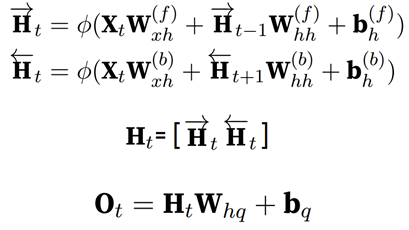

In [6]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs

Let us construct a bidirectional RNN with two hidden layers to represent single text for sentiment analysis.


In [7]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
X=torch.ones((64, 200), dtype=torch.long)
net(X).shape

torch.Size([64, 2])

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

net.apply(init_weights);

## Loading Pretrained Word Vectors

Below we load the pretrained 100-dimensional (needs to be consistent with `embed_size`) GloVe embeddings for tokens in the vocabulary.


In [9]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

Print the shape of the vectors
for all the tokens in the vocabulary.


In [10]:
#embeds = glove_embedding[vocab.idx_to_token]
embeds = glove_embedding[vocab.itos]
embeds.shape

torch.Size([50002, 100])

We use these pretrained
word vectors
to represent tokens in the reviews
and will not update
these vectors during training.


In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

## Training and Evaluating the Model

Now we can train the bidirectional RNN for sentiment analysis.


loss 0.587, train acc 0.677, test acc 0.803
1641.0 examples/sec on [device(type='cuda', index=0)]


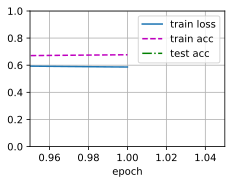

In [ ]:
lr, num_epochs = 0.01, 1
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with mutiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(list(train_iter))
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer,
                                      devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')
    
train_ch13(net, train_loader, valid_loader, loss, trainer, num_epochs, devices)

We define the following function to predict the sentiment of a text sequence using the trained model `net`.


In [ ]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

Finally, let us use the trained model to predict the sentiment for two simple sentences.


In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is bad')

'negative'

## Summary

* Pretrained word vectors can represent individual tokens in a text sequence.
* Bidirectional RNNs can represent a text sequence, such as via the concatenation of its hidden states at the initial and final time steps. This single text representation can be transformed into categories using a fully-connected layer.

